# Time - Series Forecasting with CNN

In [1]:
import numpy as np
import pandas as pd
from numpy import array
import torch
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.nn.functional as F


In [2]:
# Read the train and test data
train_set = pd.read_csv('../data/train.csv')
test_set = pd.read_csv('../data/test.csv')

In [3]:
# define a function to get a series of historical data
def split_sequence(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + window_size

        if end_idx > len(sequence) -1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

window_size = 24
train_X, train_y = split_sequence(train_set.iloc[:,1], window_size)
test_X, test_y = split_sequence(test_set.iloc[:,1], window_size)


In [4]:
class ElecDataset(Dataset):
    def __init__(self, feature, target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
        item = self.feature[index]
        label = self.target[index]

        return item, label

In [5]:
class CNN_ForecastNet(nn.Module):
    def __init__(self, window_size, prediction_size):
        super(CNN_ForecastNet, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3)
        self.avgPool_1 = nn.AvgPool1d(kernel_size=2)
        self.fc_1 = nn.Linear(in_features=(8*(window_size-2))//2, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=prediction_size)
        self.float()
    
    def forward(self, x):
        x = self.conv1d_1(x)
        x = self.avgPool_1(x)
        x = F.relu(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)

        return x

    

In [6]:
device = torch.device("cpu")
model = CNN_ForecastNet(window_size=window_size, prediction_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
criterion = nn.MSELoss()

In [7]:
train = ElecDataset(train_X.reshape(train_X.shape[0], 1, train_X.shape[1]), train_y.reshape(train_y.shape[0], 1))
test = ElecDataset(test_X.reshape(test_X.shape[0], 1, test_X.shape[1]), test_y)
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)
test_layout_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [8]:
train_losses = []
test_losses = []

def Train(model, train_loader, optimizer):

    running_loss = .0
    model.train()

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss = loss.float()
        loss.backward()
        optimizer.step()
        running_loss += loss
        

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())

    print(f'train_loss {train_loss}')

def Test(model, test_loader, optimizer):

    running_loss = .0
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, labels)
            running_loss += loss

        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.detach().numpy())

        print(f'test_loss {test_loss}')

In [9]:
epochs = 100
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1, epochs))
    Train(model, train_loader, optimizer)
    Test(model, test_loader, optimizer)

epochs 1/100
train_loss 0.14809440076351166
test_loss 0.07914090039205997
epochs 2/100


/Users/chengjiaying/anaconda3/envs/Energy/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/chengjiaying/anaconda3/envs/Energy/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 0.11447329074144363
test_loss 0.05515075204749751
epochs 3/100
train_loss 0.08339326083660126
test_loss 0.03474454602566827
epochs 4/100
train_loss 0.05778048187494278
test_loss 0.022025989934256574
epochs 5/100
train_loss 0.04075346142053604
test_loss 0.01662449620446924
epochs 6/100
train_loss 0.0318402461707592
test_loss 0.016617835465172544
epochs 7/100
train_loss 0.02901899255812168
test_loss 0.017762835438381447
epochs 8/100
train_loss 0.02830716222524643
test_loss 0.01832714017596677
epochs 9/100
train_loss 0.028071656823158264
test_loss 0.01838326874146843
epochs 10/100
train_loss 0.027907777577638626
test_loss 0.018296937271949688
epochs 11/100
train_loss 0.027765562757849693
test_loss 0.018181631668502007
epochs 12/100
train_loss 0.02759622409939766
test_loss 0.018013129836286855
epochs 13/100
train_loss 0.027369312942028046
test_loss 0.017836156000820128
epochs 14/100
train_loss 0.027150223031640053
test_loss 0.017714253602408254
epochs 15/100
train_loss 0.0269434

In [10]:
label_all = []
pred_all = []

def Test_output(model, test_layout_loader, optimizer):
    model.eval()
    label_all.clear()
    pred_all.clear()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_layout_loader):
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            label_all.append(labels.item())
            pred_all.append(preds.item())

In [11]:
Test_output(model, test_layout_loader, optimizer)


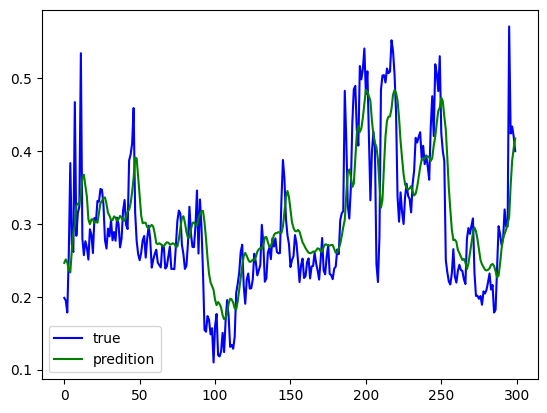

In [12]:
# With Only one Output
plt.plot(label_all[:300], color='blue', label='true')
plt.plot(pred_all[:300], color='green', label='predition')
plt.legend()
plt.show()


In [13]:
# for 96 Predition value
def split_sequence_day(sequence, window_size):
    x, y= list(), list()
    for i in range(len(sequence)):
        end_idx = i + 2*window_size

        if end_idx > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:i+window_size], sequence[i+window_size: end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

window_size_day = 96
train_X_day, train_y_day = split_sequence_day(train_set.iloc[:, 1], window_size_day)
test_X_day, test_y_day = split_sequence_day(test_set.iloc[:, 1], window_size_day)

In [23]:
class CNN_ForecastNet_Multi(nn.Module):
    def __init__(self, window_size, prediction_size):
        super(CNN_ForecastNet, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3)
        self.avgPool_1 = nn.AvgPool1d(kernel_size=2)
        self.conv1d_2 = nn.Conv1d(in_channels=8, out_channels=4, kernel_size=3)
        self.fc_1 = nn.Linear(in_features=(4*((window_size-2))//2-2), out_features=240)
        self.fc_2 = nn.Linear(in_features=240, out_features=120)
        self.fc_3 = nn.Linear(in_features=120, out_features=prediction_size)
        self.float()
    
    def forward(self, x):
        x = self.conv1d_1(x)
        x = self.avgPool_1(x)
        x = F.relu(x)
        x = self.conv1d_2(x)
        x = F.relu(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)

        return x

In [24]:
device = torch.device("cpu")
model_day = CNN_ForecastNet(window_size=window_size_day, prediction_size=96)
optimizer_day = torch.optim.Adam(model_day.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [25]:
train_day = ElecDataset(train_X_day.reshape(train_X_day.shape[0], 1, train_X_day.shape[1]), train_y_day.reshape(train_y_day.shape[0], 1, train_y_day.shape[1]))
test_day = ElecDataset(test_X_day.reshape(test_X_day.shape[0], 1, test_X_day.shape[1]), test_y_day.reshape(test_y_day.shape[0], 1, test_y_day.shape[1]))
train_loader_day = torch.utils.data.DataLoader(train_day, batch_size=64, shuffle=False)
test_loader_day = torch.utils.data.DataLoader(test_day, batch_size=64, shuffle=False)
test_layout_loader_day = torch.utils.data.DataLoader(test_day, batch_size=1, shuffle=False)

In [26]:
epochs = 100
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1, epochs))
    Train(model_day, train_loader_day, optimizer_day)
    Test(model_day, test_loader_day, optimizer_day)


epochs 1/100
train_loss 0.17359164357185364
test_loss 0.0892560465530768
epochs 2/100
train_loss 0.10132251679897308
test_loss 0.04204423643562868
epochs 3/100
train_loss 0.05247073620557785
test_loss 0.024477692947297385
epochs 4/100
train_loss 0.03582298755645752
test_loss 0.019470471118655894
epochs 5/100
train_loss 0.0313492976129055
test_loss 0.01823443062609934
epochs 6/100
train_loss 0.03025471419095993
test_loss 0.017944932892913625
epochs 7/100
train_loss 0.030005179345607758
test_loss 0.01785229233395764
epochs 8/100
train_loss 0.029940366744995117
test_loss 0.017811235827773806
epochs 9/100
train_loss 0.029912982136011124
test_loss 0.0177725475989105
epochs 10/100
train_loss 0.02989288605749607
test_loss 0.01773581850976328
epochs 11/100
train_loss 0.02987486496567726
test_loss 0.017701440327576316
epochs 12/100
train_loss 0.029858024790883064
test_loss 0.017669710464865904
epochs 13/100
train_loss 0.029841946437954903
test_loss 0.017640280496608842
epochs 14/100
train_loss 

In [18]:
def Test_output_day(model,test_layout_loader, optimizer):
    model.eval()
    label_all.clear()
    pred_all.clear()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_layout_loader):
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            label_all.append(labels[:,:,-1].item())
            pred_all.append(preds[:,-1].item())

In [19]:
Test_output_day(model_day, test_layout_loader_day, optimizer_day)

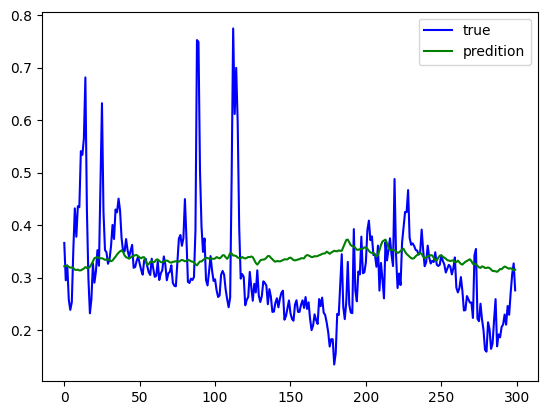

In [22]:
# With Multi Output
plt.plot(label_all[900:1200], color='blue', label='true')
plt.plot(pred_all[900:1200], color='green', label='predition')
plt.legend()
plt.show()